<a href="https://colab.research.google.com/github/EfficientDL/book/blob/main/codelabs/PyTorch_codelabs/Chapter-03-Learning-Techniques/Image-Data-Augmentations-with-Fastai.ipynb"
target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

Install the necessary packages:
* Fastai 

Import the libs used in this notebook

In [1]:
#hide

! pip install -Uqq fastai   # upgrade fastai on colab, by default is v1

# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

     |████████████████████████████████| 197 kB 4.9 MB/s 
     |████████████████████████████████| 60 kB 4.4 MB/s 


In [2]:
# hide

from fastai.imports import *
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.vision.core import PILImage

import torch

import csv

device = "cuda" if torch.cuda.is_available() else "cpu"

# Dataset and metrics visualization

APIs:
* plot_metrics(**self**: Recorder, **nrows**=None, **ncols**=None, **figsize**=None, **kwargs)


## Metrics

This is a useful function which is part of the **timeseriesAI** ([tsai](https://github.com/timeseriesAI/tsai)). It will plot the metrics tracked by Fastai after training

In [3]:
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

# Dataset creation

We use the *oxford_flowers102* to demonstrate the sample efficiency improvements. The dataset has integer class labels for the flower images. To identify the flowers by name, use the following links:
 * [Name=>Label](https://gist.github.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1)
 * [Label=>Visual](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html) 


In [4]:
path=untar_data(URLs.FLOWERS)
path.ls()

(#4) [Path('/root/.fastai/data/oxford-102-flowers/train.txt'),Path('/root/.fastai/data/oxford-102-flowers/valid.txt'),Path('/root/.fastai/data/oxford-102-flowers/jpg'),Path('/root/.fastai/data/oxford-102-flowers/test.txt')]

Let's gather all the information in a single **dictionary**, it will make things easier.

In [5]:
info = {}

# Fill the dictionary with the training data
with open(path/'train.txt') as txtfile:
  line = txtfile.readline().split()

  while len(line) > 0:
      info[path/line[0]] = [line[1], 'train']
      line = txtfile.readline().split() 
      

# Fill the dictionary with the training data
with open(path/'valid.txt') as txtfile:
  line = txtfile.readline().split()

  while len(line) > 0:
      info[path/line[0]] = [line[1], 'valid']
      line = txtfile.readline().split() 

# Fill the dictionary with the test data
with open(path/'test.txt') as txtfile:
  line = txtfile.readline().split()

  while len(line) > 0:
      info[path/line[0]] = [line[1], 'test']
      line = txtfile.readline().split() 

Now, we create two auxiliary functions, one for getting the **label** and the other for getting the **split**. With those, we will create a **Data Block**, which defines all the necessary steps to pre-process our data. We can add here the resizing of the image and the normalizations using the statistics of the dataset with which our model was pre-trained. In our case, it is **Imagenet**.

With the **Data Block** we can create **datasets** and **dataloaders**, by using `DataBlock.datasets` or `DataBlock.dataloaders` respectively.

In [6]:
def get_label(file_path):
    return info[file_path][0]

def get_split(file_path):
    return info[file_path][1]=='valid'

def get_image_files_filtered(dir_path):
    return [dir_path/im for im in os.listdir(dir_path) if info[dir_path/im][1] != 'test']

In [7]:
# Dataset image size
IMG_SIZE = 264

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                   get_items=get_image_files_filtered, 
                   splitter=FuncSplitter(get_split),
                   get_y=get_label,
                   item_tfms = Resize(IMG_SIZE), 
                   batch_tfms = Normalize.from_stats(*imagenet_stats))

In [8]:
ds = dblock.datasets(path/'jpg')

In [9]:
ds.decode

<bound method Datasets.decode of (#2040) [(PILImage mode=RGB size=667x500, TensorCategory(100)),(PILImage mode=RGB size=500x666, TensorCategory(39)),(PILImage mode=RGB size=546x500, TensorCategory(26)),(PILImage mode=RGB size=553x500, TensorCategory(5)),(PILImage mode=RGB size=750x500, TensorCategory(44)),(PILImage mode=RGB size=667x500, TensorCategory(87)),(PILImage mode=RGB size=624x500, TensorCategory(9)),(PILImage mode=RGB size=667x500, TensorCategory(10)),(PILImage mode=RGB size=629x500, TensorCategory(19)),(PILImage mode=RGB size=639x501, TensorCategory(85))...]>

We see that the images are not resized, not even Tensors. This is because **Fastai** will only apply these transformations when getting the elements. In fact, the `item_tfms` will be applied to every item individually, and `batch_tfms` will be applied very efficiently to a whole batch.

We can check what will be the input of the model by creating the dataloaders.

In [10]:
dl = dblock.dataloaders(path/'jpg')

In [11]:
b=dl.one_batch()

In [12]:
b[0].shape

torch.Size([64, 3, 264, 264])

Moreover, **Fastai** allow us to nicely visualize a batch from our trainig or validation dataloaders.

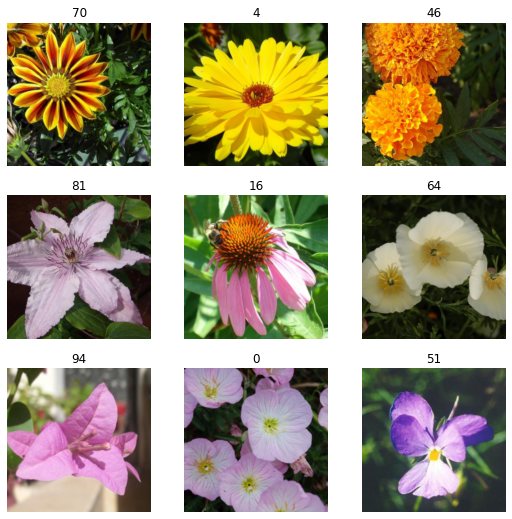

In [13]:
dl.show_batch()

# Model architecture

We use a ResNet50 model pre-trained on the ImageNet dataset. The oxford_flowers102 is a small dataset with 1020 training images and 1020 validation images. Such a small sample is insufficient to train a model from scratch. However, with the pre-trained weights, this dataset is more than enough to achieve decent predictions. The model is exposed through a **model** variable. 

**Fastai** provides us with an easy way the pretrained architecture to the specific problem that we are treating. We will create a **learner** which wraps up the dataloaders, the models and the metrics to be tracked, as well as other configurations regarding the training such as dropout probability here `ps`, or the learning rate.

In [14]:
# collapse-show

DROPOUT_RATE = 0.2
LEARNING_RATE = 0.0002

learn = vision_learner(dl, resnet50, metrics=accuracy, 
                       ps = DROPOUT_RATE, lr = LEARNING_RATE)
learn.summary()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Sequential (Input shape: 64 x 3 x 264 x 264)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 132 x 132 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 66 x 66   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 66 x 66  
Conv2d                                    16384      False     
BatchNorm2d                        

**Quick Note:** As we can see there are some discrepancies between our model and the one presented in the book, summarized in the picture below.

![](https://raw.githubusercontent.com/XanaGA/posts_en/081285d7ce39e36cdc04a327deb2593656a6f716/images/resnet_tf.png)

* **Batch size:** It is visible in our case. Why is that? Because the **learner** also wraps up the dataloadoader, it knows what is the batch size, by default 64.

* **Head:** As mentioned, Fastai does two things automatically for us. First, it decides where to "cut" the head of our model, and then it replaces it with a non-trained head, different for each architecture. This can be done automatically because resnet50 is a well-known architecture, but if we want to use another one we have tools that allow us to do this. In our case instead of just having a linear layer right after the last **B x 2048 x 9 x 9** convolutional block, we have an adaptative pooling followed by two smaller linear layers. 

* **Trainable params:** Those are all the parameters from the new custom head, as the rest of the model will be *frozen*. Despite our head seeming more complex than simply adding a linear layer (like in the book), we can see it reduces the number of trainable parameters from **16,920,678** to **2,211,712**, so we have **x7** fewer parameters to train. Efficient architectures will be further discussed in **Chapter 4**.

* **Non-Trainable params:** The discrepancy in those numbers is caused by how **Pytorch** and **Tensorflow** count the number of parameters of **BatchNorm** layers, explained in **Chapter 2**.

To make it as simmilar as the codelab from the "[Efficient Deep Learning Book](https://efficientdlbook.com/)" the following code will create a learner with an identical model architecture as the one presented there, being the head a single linear layer. Although, you are encouraged to try with both settings!

In [15]:
# collapse-show

custom_head = nn.Sequential(nn.Flatten(), 
                           nn.Dropout(DROPOUT_RATE), 
                           nn.Linear(165888, 102)).to(device)

learn = vision_learner(dl, resnet50, metrics=accuracy, 
                       ps = DROPOUT_RATE, lr = LEARNING_RATE,
                       custom_head = custom_head)
learn.summary()

Sequential (Input shape: 64 x 3 x 264 x 264)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 132 x 132 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 66 x 66   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 66 x 66  
Conv2d                                    16384      False     
BatchNorm2d                        

# Training Setup

In this notebook we will just train for a certain number of epoch. Note that this is not the common way of using Fastai. You can check how it is recommended to train our models with this libraries in the following [post](https://xanaga.github.io/posts_en/data_augmentation/vision/efficient_deeplearning/2022/06/09/EDL-_Chapter_3_Image_Data_Augmentations_the_Fastai's_way.html).

In [16]:
def train(learner, epochs=100):
  # Save the best weights during training
  learner.add_cb(SaveModelCallback(monitor='accuracy',
                                     comp=np.greater,
                                     fname='best_model_acc'))
  learner.fit(epochs)

# Experiments

## baseline

In [18]:
dl = dblock.dataloaders(path/'jpg', bs=24)

custom_head = nn.Sequential(nn.Flatten(), 
                           nn.Dropout(DROPOUT_RATE), 
                           nn.Linear(165888, 102)).to(device)

learn = vision_learner(dl, resnet50, metrics=accuracy,
                       ps = DROPOUT_RATE, lr = LEARNING_RATE,
                       custom_head = custom_head)
train(learn, 100)

epoch,train_loss,valid_loss,accuracy,time
0,11.422440,3.943022,0.485294,00:26
1,4.283461,2.712639,0.577451,00:24
2,1.845120,2.395402,0.650980,00:24
3,0.992933,2.528773,0.659804,00:24
4,0.595930,3.215954,0.610784,00:24
5,0.504704,3.173305,0.609804,00:25
6,0.452547,4.002334,0.594118,00:24
7,0.313761,2.803615,0.674510,00:24
8,0.191733,2.300151,0.721569,00:24
9,0.185051,2.998298,0.663725,00:24


Better model found at epoch 0 with accuracy value: 0.4852941036224365.
Better model found at epoch 1 with accuracy value: 0.5774509906768799.
Better model found at epoch 2 with accuracy value: 0.6509804129600525.
Better model found at epoch 3 with accuracy value: 0.6598039269447327.
Better model found at epoch 7 with accuracy value: 0.6745098233222961.
Better model found at epoch 8 with accuracy value: 0.7215686440467834.
Better model found at epoch 16 with accuracy value: 0.7235293984413147.
Better model found at epoch 21 with accuracy value: 0.7696078419685364.
Better model found at epoch 28 with accuracy value: 0.7882353067398071.
Better model found at epoch 35 with accuracy value: 0.7941176295280457.
Better model found at epoch 47 with accuracy value: 0.8009803891181946.
Better model found at epoch 57 with accuracy value: 0.8039215803146362.
Better model found at epoch 63 with accuracy value: 0.8068627715110779.
Better model found at epoch 69 with accuracy value: 0.8166666626930237

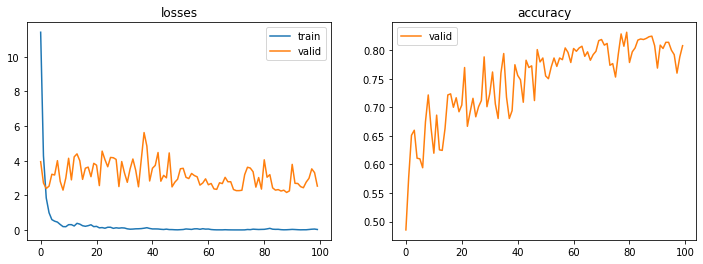

In [19]:
learn.recorder.plot_metrics()

## basicaug-hflip-rotate-0.1

**Fastai** also provides a combination of transformations that can be applied to our data. Those are used with the `aug_transforms` function. 

By setting the correct arguments (shown in the code) we can replicate the behavior of just using horizontal flipping and a random rotation with a probability 0'1. Although, it is very easy and straightforward to combine different augmentations including lighting and more complex affine transformations.

In [20]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                   get_items=get_image_files_filtered, 
                   splitter=FuncSplitter(get_split),
                   get_y=get_label,
                   item_tfms = Resize(IMG_SIZE), 
                   batch_tfms = [*aug_transforms(do_flip=True, max_rotate=10,
                                                min_zoom=1., max_zoom=1.,
                                                max_warp=0., p_affine=0.1,
                                                p_lighting=0.),
                                 Normalize.from_stats(*imagenet_stats)])

dl = dblock.dataloaders(path/'jpg', bs=24)

We can check how an image will be augmented before going into the network using the `show_batch` function with the attribute `unique`

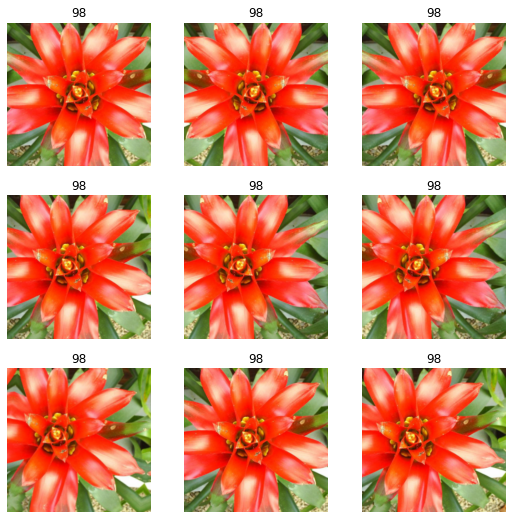

In [21]:
dl.show_batch(unique=True)

Just as an example of how different transformation can be applied we will create a toy dataloader. You can skip this cell if you want.

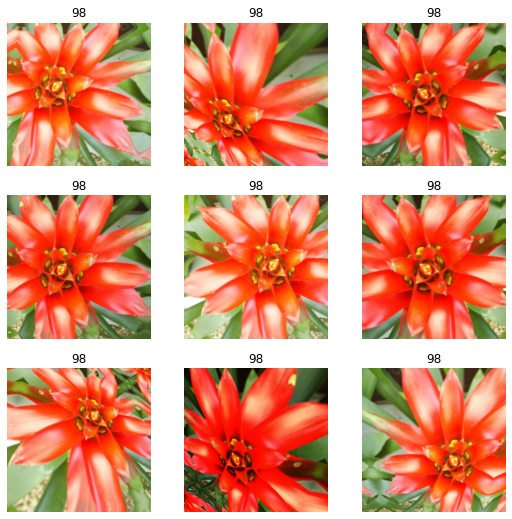

In [26]:
toy_dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                   get_items=get_image_files_filtered, 
                   splitter=FuncSplitter(get_split),
                   get_y=get_label,
                   item_tfms = Resize(IMG_SIZE), 
                   batch_tfms = [*aug_transforms(mult=2.),
                                 Normalize.from_stats(*imagenet_stats)])

toy_dl = toy_dblock.dataloaders(path/'jpg', bs=24)
toy_dl.show_batch(unique=True)

In [ ]:
custom_head = nn.Sequential(nn.Flatten(), 
                           nn.Dropout(DROPOUT_RATE), 
                           nn.Linear(165888, 102)).to(device)

learn = vision_learner(dl, resnet50, metrics=accuracy,
                       ps = DROPOUT_RATE, lr = LEARNING_RATE,
                       custom_head = custom_head)
train(learn, 100)

epoch,train_loss,valid_loss,accuracy,time
0,11.205285,4.571277,0.476471,00:24
1,4.328070,2.474746,0.618627,00:26
2,2.137901,2.310121,0.671569,00:25
3,1.147776,2.304079,0.679412,00:25
4,0.736298,1.806975,0.753922,00:25
5,0.678770,3.309883,0.646078,00:25
6,0.578342,2.531569,0.714706,00:25
7,0.448315,2.340222,0.760784,00:24
8,0.559795,2.271210,0.739216,00:25
9,0.403526,2.335564,0.773529,00:25


Better model found at epoch 0 with accuracy value: 0.47647058963775635.
Better model found at epoch 1 with accuracy value: 0.6186274290084839.
Better model found at epoch 2 with accuracy value: 0.6715686321258545.
Better model found at epoch 3 with accuracy value: 0.679411768913269.
Better model found at epoch 4 with accuracy value: 0.7539215683937073.
Better model found at epoch 7 with accuracy value: 0.7607843279838562.
Better model found at epoch 9 with accuracy value: 0.7735294103622437.
Better model found at epoch 14 with accuracy value: 0.7852941155433655.
Better model found at epoch 21 with accuracy value: 0.7911764979362488.
Better model found at epoch 24 with accuracy value: 0.8127450942993164.
Better model found at epoch 26 with accuracy value: 0.8294117450714111.
Better model found at epoch 29 with accuracy value: 0.843137264251709.
Better model found at epoch 57 with accuracy value: 0.8441176414489746.
Better model found at epoch 67 with accuracy value: 0.8519607782363892.


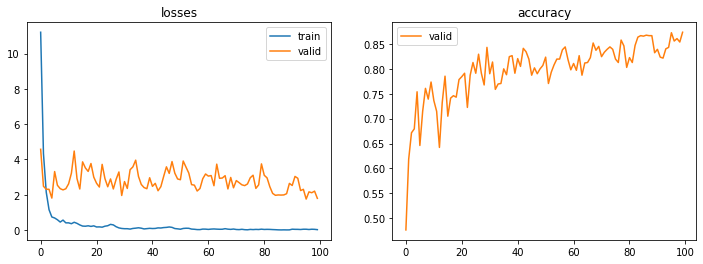

In [ ]:
learn.recorder.plot_metrics()

With just a small data augmentation we impoved the accuracy of our model in **4%**